In [1]:
import os
import yaml
import copy
import pickle
import ml_collections
import wandb, signatory

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import path as pt
from tqdm import tqdm
sns.set_style("darkgrid")  # 원하는 스타일 선택

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from src.utils import *
#from src.evaluation.summary import full_evaluation

In [2]:
# Load configuration dict
config_dir = 'configs/config.yaml'
with open(config_dir) as file:
    config = ml_collections.ConfigDict(yaml.safe_load(file))

if (config.device == "cuda" and torch.cuda.is_available()):
    config.update({"device": "cuda:1"}, allow_val_change=True)
    torch.cuda.set_device(0)
else:
    config.update({"device": "cpu"}, allow_val_change=True)

set_seed(config.seed)

### Data Preprocess

In [3]:
def rolling_window(data, window_size):
    n_windows = data.shape[0] - window_size + 1
    windows = np.zeros((n_windows, window_size, data.shape[1]))
    for idx in range(n_windows):
        windows[idx] = data[idx:idx + window_size]
    return windows

# Step 1: Load and preprocess data
df = pd.read_csv(f"./data/{config.file_name}.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.apply(pd.to_numeric).astype(float)

# Step 2: Compute log returns
log_returns = np.diff(np.log(df), axis=0)
print(log_returns.shape)

# Step 3: Scale the log returns
log_returns_scaled, scalers = scaling(log_returns)

# Step 4: Prepare initial prices and create rolling windows
init_price = torch.from_numpy(np.array(df)[:-(config.n_steps), :]).float().unsqueeze(1)
log_returns_scaled = torch.from_numpy(rolling_window(log_returns_scaled, config.n_steps)).float()
print('init_price:', init_price.shape)
print('log_returns_scaled:', log_returns_scaled.shape)

(5720, 6)


/workspace/Task_Generation/QuantGAN copy/src/preprocess/gaussianize.py:179: UserWarning: Warning: No convergence after 100 iterations. Increase max_iter.
  warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)
/workspace/Task_Generation/QuantGAN copy/src/preprocess/gaussianize.py:179: UserWarning: Warning: No convergence after 100 iterations. Increase max_iter.
  warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)


init_price: torch.Size([5593, 1, 6])
log_returns_scaled: torch.Size([5593, 128, 6])


### Generative models for time series generation

### Data Construction

We divide the data into training and validation set for the offline evaluation of our model

In [4]:
perm_idx = torch.randperm(log_returns_scaled.shape[0])
train_size = int(0.7*log_returns_scaled.shape[0])

training_data = log_returns_scaled[perm_idx[:train_size]]
train_init_price = init_price[perm_idx[:train_size]]
test_data = log_returns_scaled[perm_idx[train_size:]]
test_init_price = init_price[perm_idx[train_size:]]

print("training_data: ", training_data.shape)
print("test_data: ", test_data.shape)

training_data:  torch.Size([3915, 128, 6])
test_data:  torch.Size([1678, 128, 6])


In [5]:
# """ Permutation Augmentation """
# from itertools import permutations

# def augment_with_permutation(data, num_subsequences=4):
#     batch_size, seq_length, feature_dim = data.shape    
#     subseq_length = seq_length // num_subsequences    
#     if seq_length % num_subsequences != 0:
#         raise ValueError("Sequence length must be divisible by num_subsequences.")

#     # 가능한 모든 순열 생성
#     perm_indices = list(permutations(range(num_subsequences)))

#     augmented_data = []
#     for i in range(batch_size):
#         single_sequence = data[i]
#         subsequences = single_sequence.split(subseq_length, dim=0)
        
#         # 각 순열에 대해 증강
#         for perm in perm_indices:
#             permuted_sequence = torch.cat([subsequences[j] for j in perm], dim=0)
#             augmented_data.append(permuted_sequence)

#     # 최종 텐서로 결합
#     augmented_data = torch.stack(augmented_data, dim=0)
#     return augmented_data


# # augmented_training_data = augment_with_permutation(training_data)
# # training_data = torch.cat([training_data, augmented_training_data], dim=0)
# training_data = augment_with_permutation(training_data)
# print("Augmented training_data shape: ", training_data.shape)


Load the dataset


In [6]:
training_set = TensorDataset(training_data)
test_set = TensorDataset(test_data)

train_dl = DataLoader(training_set, batch_size=config.batch_size, shuffle=True)
test_dl = DataLoader(test_set, batch_size=config.batch_size, shuffle=True)

### Generative model

Here we construct a generator and a discriminator for this task. Both the generator and discriminator takes as input the time series. Then we have the training algorithm TailGANTrainer.

### Initialize the generator, discriminator and the trainer

In [7]:
from src.baselines.networks.discriminators import UserDiscriminator
from src.baselines.networks.generators import UserGenerator
from src.baselines.trainer import *

generator = UserGenerator(config)
discriminator = UserDiscriminator(config)
trainer = GANTrainer(G=generator, D=discriminator, train_dl=train_dl, config=config)

### Model training and saving

In [8]:
# # Model training
#trainer.fit()

# Model Evaluation

### MVFIT-GAN

In [9]:
from scipy.stats import entropy, wasserstein_distance, ks_2samp, spearmanr, kendalltau
from statsmodels.tsa.stattools import acf
from scipy.spatial.distance import jensenshannon

full_name = "indices_300_256_G_lr_0.0002_D_lr_0.0001_noise_6_hidden_dim_160"

In [10]:
""" Find the best epochs based on 100 days cumulative distribution """
window = 100
gen_tmp = UserGenerator(config)
min_dist = float('inf')  
best_epoch = 0


def compute_avg_emd(real_data, fake_data, window):
    """
    Compute the Earth Mover's Distance (EMD) for real and fake data over a rolling window.
    """
    emd = 0
    for i in range(real_data.shape[1]):  # Iterate over features
        real_dist = rolling_window(real_data[:, i, :].T, window).sum(axis=1).ravel()
        fake_dist = rolling_window(fake_data[:, i, :].T, window).sum(axis=1).ravel()
        emd += wasserstein_distance(real_dist, fake_dist)
    return emd

batch_size = 1000
for epoch in range(200, 251, 5):
    
    # Load generator for the current epoch
    generator.load_state_dict(torch.load(f'./results/models/{full_name}/Generator_{epoch}.pt'))
    generator.to(config.device)
    generator.eval()
    
    # Generate fake data
    noise = torch.randn(batch_size, config.noise_dim, config.n_steps, device=config.device)
    with torch.no_grad():        
        fake= generator(noise)                
        
    # Inverse scaling for real and fake data
    print(fake.shape)
    print(training_data.transpose(1, 2).shape)
    fake_data = inverse_scaling(fake, scalers)        
    real_data = inverse_scaling(training_data.transpose(1, 2), scalers)
    
    # Compute EMD
    emd = compute_avg_emd(real_data, fake_data, window)

    # Update best epoch if current EMD is lower
    if emd < min_dist:
        min_dist = emd
        best_epoch = epoch
        print(f"min_distance: {min_dist:.3f}, best_epoch: {best_epoch}") 

generator.load_state_dict(torch.load(f'./results/models/{full_name}/Generator_{best_epoch}.pt'))
generator.to(config.device)
generator.eval()
print()

torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
min_distance: 0.638, best_epoch: 200
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
min_distance: 0.455, best_epoch: 215
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
min_distance: 0.352, best_epoch: 220
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
min_distance: 0.249, best_epoch: 230
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])
torch.Size([1000, 6, 128])
torch.Size([3915, 6, 128])



In [11]:
""" Fake data와 Test data를 비교 """
batch_size = 2000
noise = torch.randn(batch_size, config.noise_dim, config.n_steps, device=config.device)
with torch.no_grad():
    fake = generator(noise)

fake_data = inverse_scaling(fake, scalers)
real_data = inverse_scaling(test_data.transpose(1, 2), scalers)

# 각 feature의 전체 최소값 및 최대값 계산
min_vals = real_data.min(axis=(0, 2), keepdims=True)  # Shape: (1, 5, 1)
max_vals = real_data.max(axis=(0, 2), keepdims=True)  # Shape: (1, 5, 1)

# 마스크 계산 (모든 샘플이 범위 내에 있는지 확인)
mask = np.all((fake_data >= min_vals * 1.5) & (fake_data <= max_vals * 1.5), axis=(1, 2))

# 마스크를 적용하여 fake_data 필터링
print(real_data.shape, type(real_data))
print(fake_data.shape, type(fake_data))
fake_data = fake_data[mask]
print(f"Filtered shape: {fake_data.shape}")

(1678, 6, 128) <class 'numpy.ndarray'>
(2000, 6, 128) <class 'numpy.ndarray'>
Filtered shape: (1712, 6, 128)


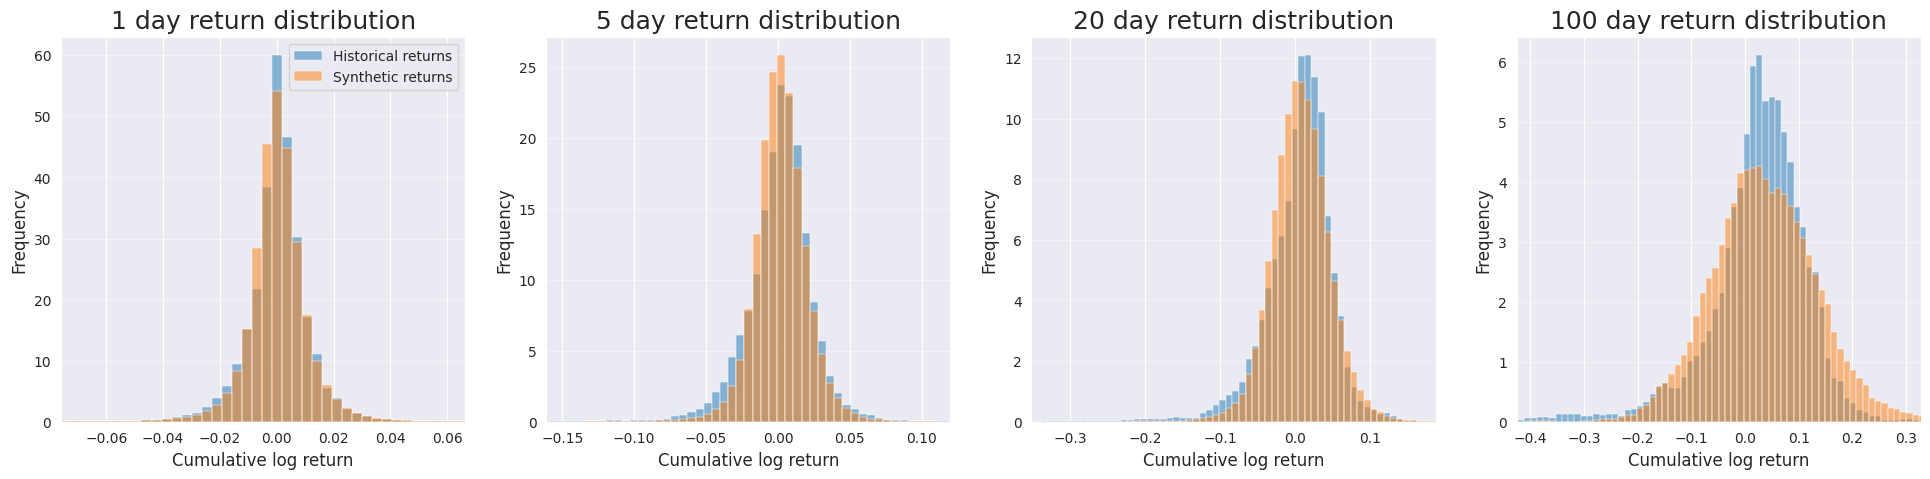

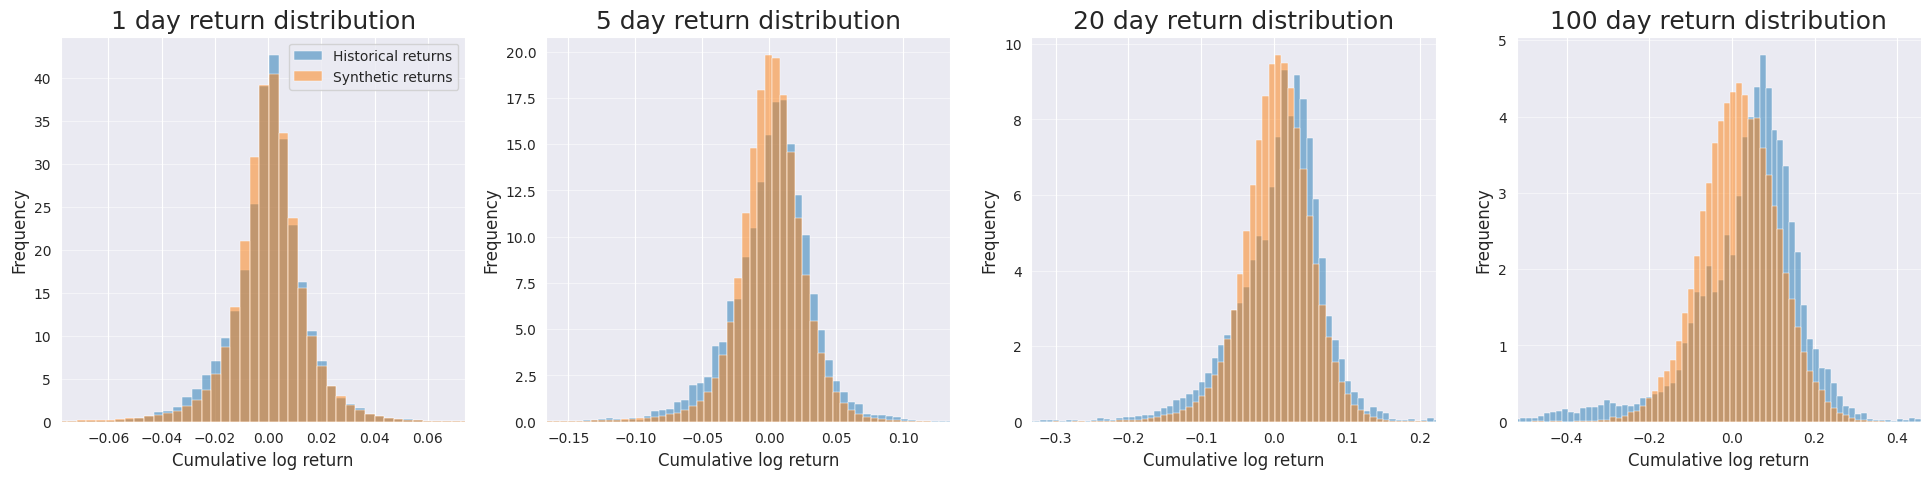

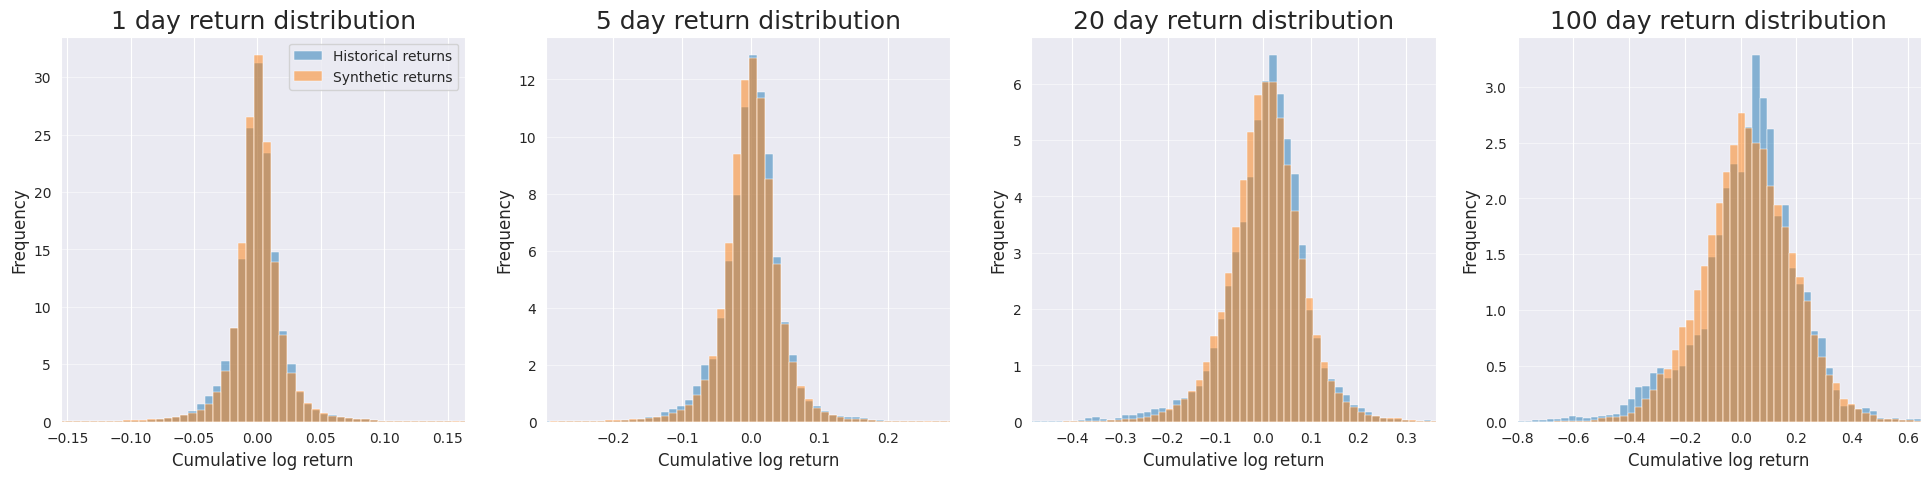

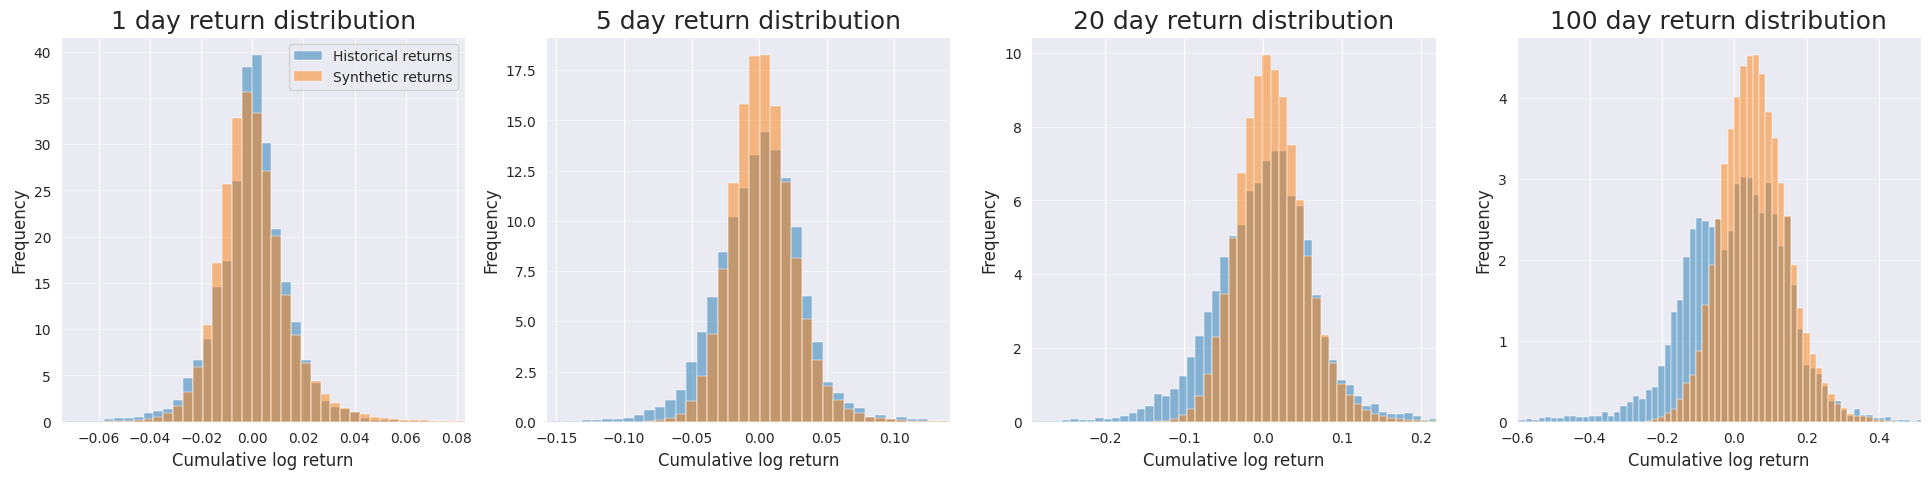

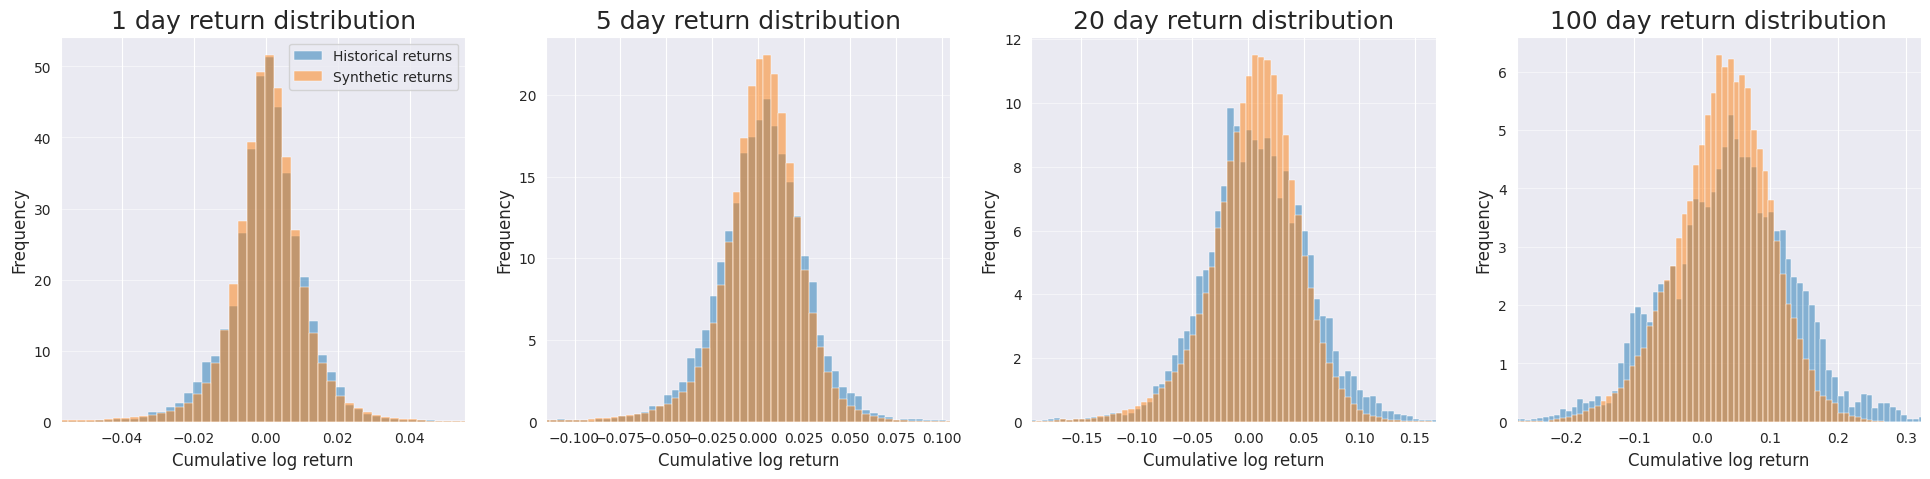

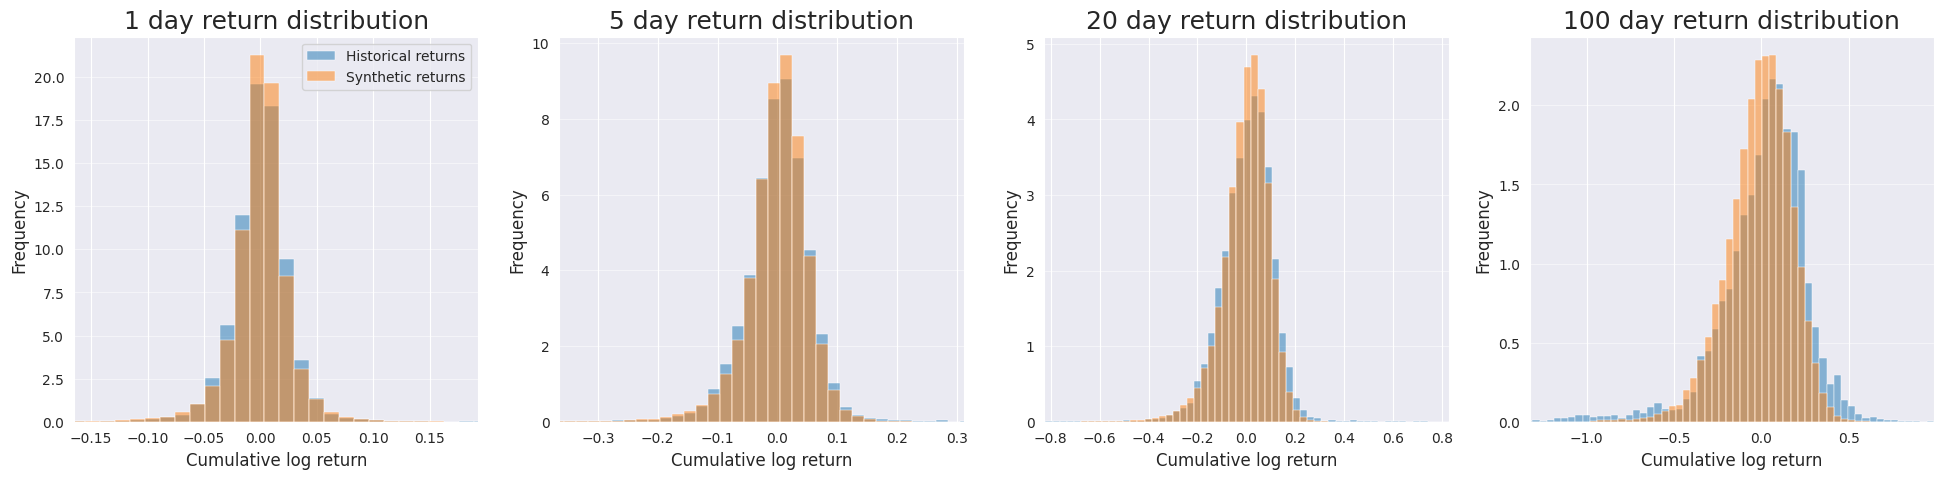

{'EMD':               EMD 0   EMD 1   EMD 2   EMD 3   EMD 4   EMD 5  EMD_avg
 window size                                                         
 1            0.0005  0.0008  0.0009  0.0015  0.0006  0.0015   0.0010
 5            0.0033  0.0047  0.0025  0.0060  0.0025  0.0033   0.0037
 20           0.0057  0.0123  0.0068  0.0149  0.0061  0.0110   0.0095
 100          0.0187  0.0387  0.0178  0.0541  0.0193  0.0562   0.0341,
 'KL':                KL 0    KL 1    KL 2    KL 3    KL 4    KL 5
 window size                                                
 1            0.0118  0.0114  0.0054  0.0417  0.0105  0.0139
 5            0.0413  0.0459  0.0107  0.1660  0.0247  0.0214
 20           0.0667  0.0926  0.0391  0.3298  0.0513  0.0733
 100          0.1609  0.2776  0.0863  0.7933  0.2576  0.2258,
 'JS':                JS 0    JS 1    JS 2    JS 3    JS 4    JS 5
 window size                                                
 1            0.0540  0.0538  0.0364  0.0855  0.0502  0.0511
 5        

: 

In [ ]:
""" Visualize the distribution of the real and fake data """
fake_list = [fake_data[:, i, :] for i in range(fake_data.shape[1])]
real_list = [real_data[:, i, :] for i in range(real_data.shape[1])]

# Plot the distribution of the real and fake data
windows = [1, 5, 20, 100]
for j in range(config.n_vars):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 5))  

    for i in range(len(windows)):
        col = i

        real_dist = rolling_window(real_list[j].T, windows[i]).sum(axis=1).ravel()
        fake_dist = rolling_window(fake_list[j].T, windows[i]).sum(axis=1).ravel()        
        
        min_val = real_dist.min()
        max_val = real_dist.max()
        
        bins = np.linspace(min_val, max_val, 81)  
        
        sns.histplot(real_dist, bins=bins, kde=False, ax=axs[col], color='tab:blue', alpha=0.5, stat='density')
        sns.histplot(fake_dist, bins=bins, kde=False, ax=axs[col], color='tab:orange', alpha=0.5, stat='density')

        axs[col].set_xlim(*np.quantile(real_dist, [0.001, .999]))
        
        axs[col].set_title('{} day return distribution'.format(windows[i]), size=18)
        axs[col].yaxis.grid(True, alpha=0.5)
        axs[col].set_xlabel('Cumulative log return', fontsize=12)
        axs[col].set_ylabel('Frequency', fontsize=12)

    axs[0].legend(['Historical returns', 'Synthetic returns'])

plt.show()

def calculate_distribution_scores(real, fake, num_G, windows):
    scores = {
        'EMD': np.zeros((num_G, len(windows))),
        'KL': np.zeros((num_G, len(windows))),
        'JS': np.zeros((num_G, len(windows))),
        'KS': np.zeros((num_G, len(windows)))
    }

    for i in range(num_G):
        for j in range(len(windows)):
            real_dist = rolling_window(real[i].T, windows[j]).sum(axis=1).ravel()
            fake_dist = rolling_window(fake[i].T, windows[j]).sum(axis=1).ravel()
            
            np.random.shuffle(real_dist)
            np.random.shuffle(fake_dist)
            
            # Calculate EMD
            scores['EMD'][i, j] = wasserstein_distance(real_dist, fake_dist)
            
            # Calculate KS Statistic
            scores['KS'][i, j], _ = ks_2samp(real_dist, fake_dist)                                    
            
            # Create histograms to estimate the probability distributions
            real_hist, bin_edges = np.histogram(real_dist, bins=100, density=True)
            fake_hist, _ = np.histogram(fake_dist, bins=bin_edges, density=True)
            
            # Normalize the histograms to get probability distributions
            real_prob = real_hist / np.sum(real_hist)
            fake_prob = fake_hist / np.sum(fake_hist)
            
            # Calculate KL Divergence
            kl_divergence = entropy(real_prob + 1e-10, fake_prob + 1e-10)
            scores['KL'][i, j] = kl_divergence

            # Calculate JS Divergence
            js_divergence = jensenshannon(real_prob + 1e-10, fake_prob + 1e-10)
            scores['JS'][i, j] = js_divergence
                
    df_scores = {}
    for metric, data in scores.items():
        data = np.round(data, decimals=4)
        df_scores[metric] = pd.DataFrame(data.T, index=windows, columns=[f'{metric} {i}' for i in range(num_G)])
        
    emd_avg = np.mean(scores['EMD'], axis=0)
    df_scores['EMD']['EMD_avg'] = np.round(emd_avg, decimals=4)
    
    return df_scores

# Calculate the distribution scores
windows = pd.Series([1, 5, 20, 100], name='window size')

results_emd = calculate_distribution_scores(real_list, fake_list, config.n_vars, windows)
results_emd

0
[ 0.00062726 -0.00071957  0.00267053 ...  0.00910639 -0.01092561
  0.00401746]


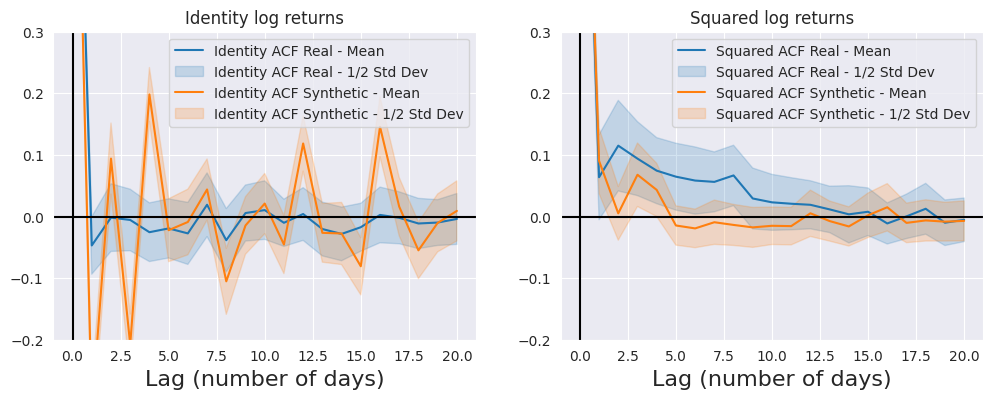

1
[ 0.00620007  0.00142031  0.0027902  ...  0.0215486  -0.00966765
  0.00447001]


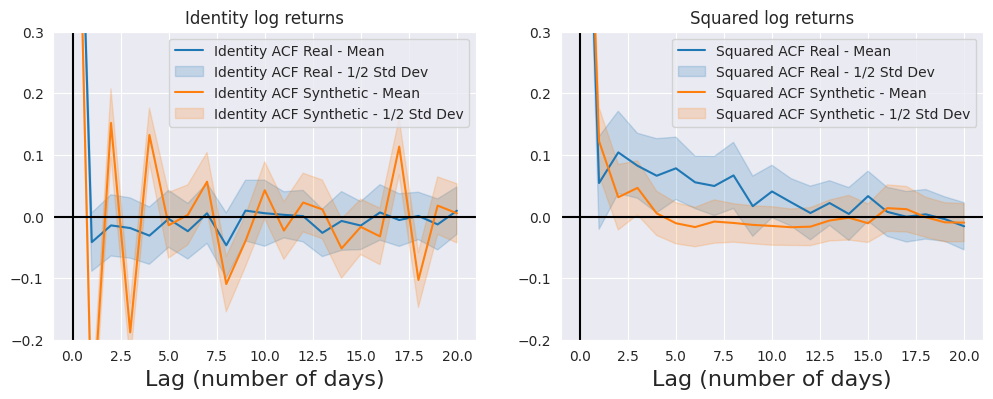

2
[-0.00829998  0.01874491  0.00532504 ...  0.01020506 -0.02358034
  0.00302273]


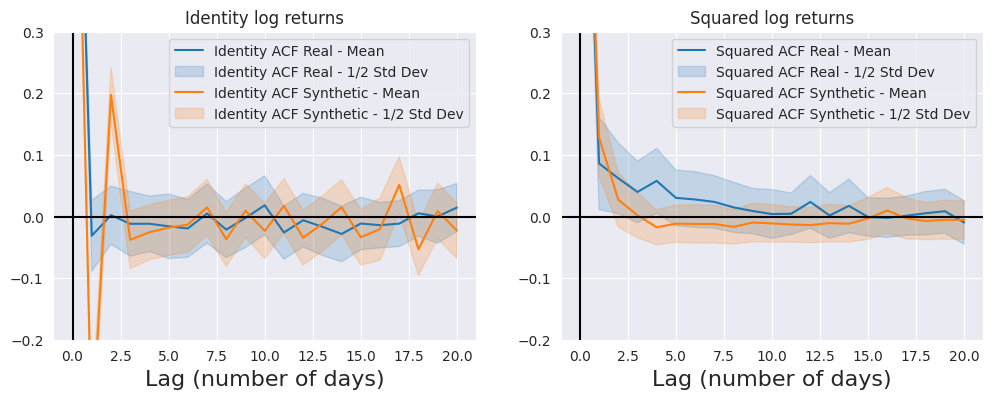

3
[-0.01993947  0.02297158 -0.00433356 ...  0.01162652 -0.00729292
  0.00681403]


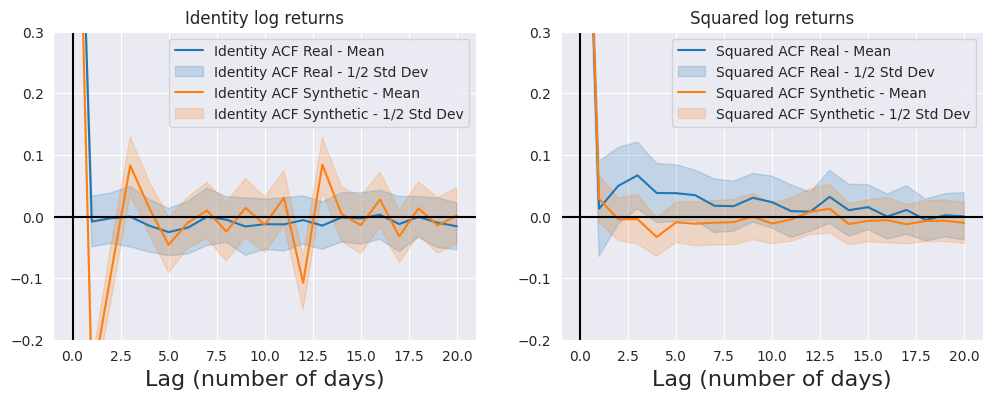

4
[0.0033631  0.01511814 0.00355    ... 0.0031648  0.01143194 0.00389243]


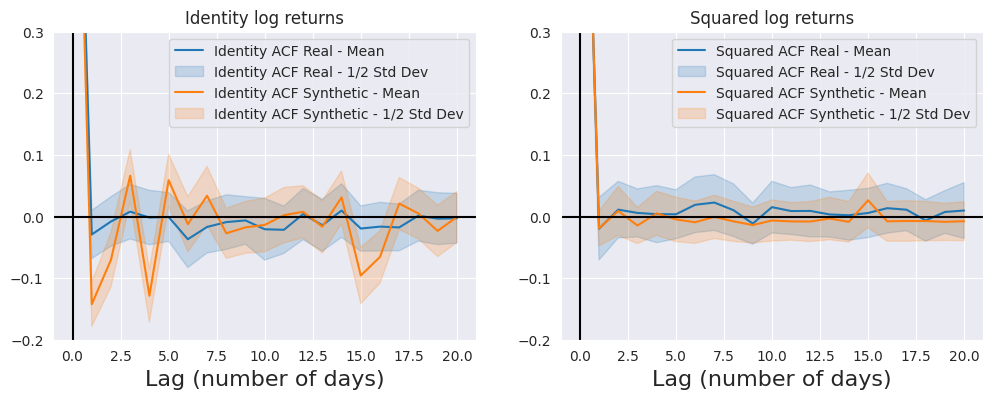

5
[ 0.00524363  0.03878861 -0.00950692 ...  0.00201998  0.02930874
  0.02463713]


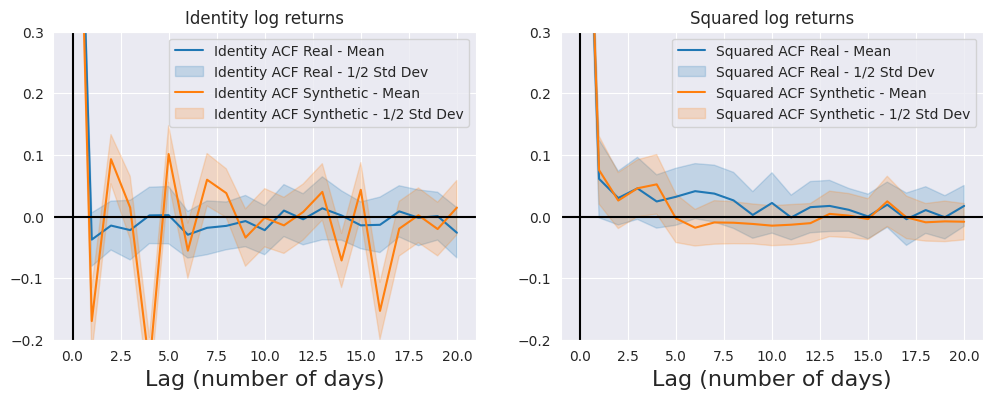

In [13]:
""" visualizing acf plots """
def plot_acf_comparison(real_list, fake_list, num_G, lags=20):    
    data_types = ['Identity', 'Squared']
    data_transforms = [lambda x: x, np.square]  
    titles = ['Identity log returns', 'Squared log returns']

    for i in range(num_G):
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))  
        print(i)
        print(real_list[i][:, 0])
        for ax, data_type, transform, title in zip(axs, data_types, data_transforms, titles):
            
            transformed_real = transform(real_list[i])
            transformed_fake = transform(fake_list[i])
            
            acf_real = np.array([acf(ts, nlags=lags) for ts in transformed_real])
            acf_fake = np.array([acf(ts, nlags=lags) for ts in transformed_fake])
            
            mean_real = np.mean(acf_real, axis=0)
            std_real = np.std(acf_real, axis=0)
            mean_fake = np.mean(acf_fake, axis=0)
            std_fake = np.std(acf_fake, axis=0)
                        
            ax.plot(mean_real, label=f'{data_type} ACF Real - Mean', color='tab:blue')
            ax.fill_between(range(lags+1), mean_real - 0.5*std_real, mean_real + 0.5*std_real, color='tab:blue', alpha=0.2,
                            label=f'{data_type} ACF Real - 1/2 Std Dev')        
            ax.plot(mean_fake, label=f'{data_type} ACF Synthetic - Mean', color='tab:orange')
            ax.fill_between(range(lags+1), mean_fake - 0.5*std_fake, mean_fake + 0.5*std_fake, color='tab:orange', alpha=0.2,
                            label=f'{data_type} ACF Synthetic - 1/2 Std Dev')
            
            ax.set_ylim(-0.20, 0.3)
            ax.set_title(title)
            ax.grid(True)
            ax.axhline(y=0, color='k')
            ax.axvline(x=0, color='k')
            ax.set_xlabel('Lag (number of days)', fontsize=16)
            ax.legend()

        plt.show()
        
plot_acf_comparison(real_list, fake_list, config.n_vars, lags=20)

Fake Data Mean Correlation Matrix:
[[ 1.     0.854  0.641  0.302  0.223  0.212]
 [ 0.854  1.     0.701  0.241  0.247  0.169]
 [ 0.641  0.701  1.     0.01   0.261  0.048]
 [ 0.302  0.241  0.01   1.    -0.307  0.376]
 [ 0.223  0.247  0.261 -0.307  1.     0.13 ]
 [ 0.212  0.169  0.048  0.376  0.13   1.   ]]

Real Data Mean Correlation Matrix:
[[ 1.     0.849  0.734  0.207 -0.021  0.201]
 [ 0.849  1.     0.609  0.227 -0.     0.171]
 [ 0.734  0.609  1.     0.163 -0.074  0.14 ]
 [ 0.207  0.227  0.163  1.     0.046  0.133]
 [-0.021 -0.    -0.074  0.046  1.     0.196]
 [ 0.201  0.171  0.14   0.133  0.196  1.   ]]


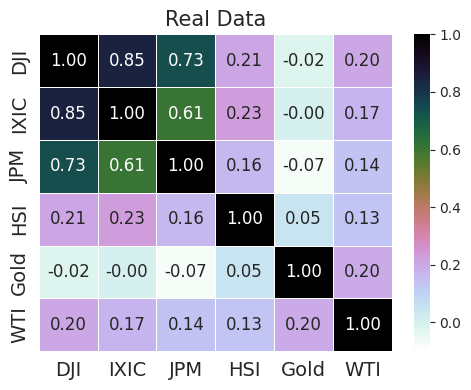

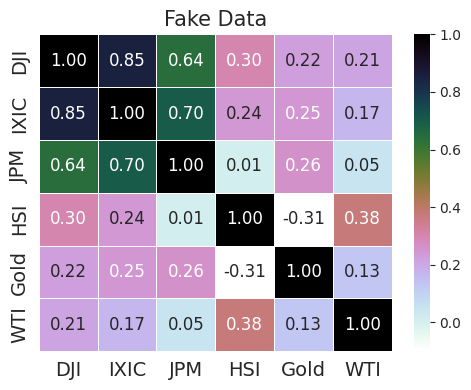

In [14]:
# Function to calculate mean correlation across all samples
def calculate_mean_feature_correlations(data):
    num_samples = data.shape[0]
    correlations = []

    # 각 샘플에 대해 상관관계를 계산하고 결과를 저장
    for i in range(num_samples):
        sample = data[i, :, :]
        correlation_matrix = np.corrcoef(sample, rowvar=False)  # Correlation between features
        correlations.append(correlation_matrix)

    # 저장된 상관행렬들의 평균을 계산
    mean_correlation_matrix = np.mean(correlations, axis=0)
    return mean_correlation_matrix

# Calculate the mean correlations for both datasets
fake_mean_correlation = calculate_mean_feature_correlations(np.transpose(fake_data, (0, 2, 1)))
real_mean_correlation = calculate_mean_feature_correlations(np.transpose(real_data, (0, 2, 1)))

# Print results rounded to three decimal places
print("Fake Data Mean Correlation Matrix:")
print(np.round(fake_mean_correlation, 3))

print("\nReal Data Mean Correlation Matrix:")
print(np.round(real_mean_correlation, 3))

def plot_correlation_heatmap(correlation_matrix, title, feature_names):
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(correlation_matrix, annot=True, cmap='cubehelix_r', linewidths=.5, ax=ax, fmt=".2f", annot_kws={"size": 12}, vmin=-0.1, vmax=1)
    
    # 축 이름 설정
    ax.set_xticklabels(feature_names, fontsize=12)
    ax.set_yticklabels(feature_names, fontsize=12)
    
    # 제목 및 시각적 요소
    ax.set_title(title, fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    plt.show()

feature_names = ['DJI', 'IXIC', 'JPM', 'HSI', 'Gold', 'WTI']
plot_correlation_heatmap(real_mean_correlation, "Real Data", feature_names)
plot_correlation_heatmap(fake_mean_correlation, "Fake Data", feature_names)


In [15]:
""" 누적 로그 리턴 플롯 """
# def compute_cumulative_log_returns(data):
#     return np.cumsum(data, axis=2)  # Cumulative sum along the time axis

# # 누적 로그 리턴 계산
# real_cumulative_log_returns = compute_cumulative_log_returns(real_data)  # Shape: (batch_size, num_assets, sequence_length)
# fake_cumulative_log_returns = compute_cumulative_log_returns(fake_data)  # Shape: (batch_size, num_assets, sequence_length)

# # 각 자산별 플롯 생성
# num_assets = real_data.shape[1]
# for asset_idx in range(num_assets):
#     # Real 데이터 플롯
#     plt.figure(figsize=(12, 6))
#     for i in range(real_cumulative_log_returns.shape[0]):  # 최대 10개의 샘플만 플롯
#         plt.plot(real_cumulative_log_returns[i, asset_idx, :], alpha=0.6)
#     plt.title(f'Real Cumulative Log Returns for Asset {asset_idx + 1}')
#     plt.xlabel('Time Step')
#     plt.ylabel('Cumulative Log Return')
#     plt.grid(True)
#     plt.show()

#     # Fake 데이터 플롯
#     plt.figure(figsize=(12, 6))
#     for i in range(fake_cumulative_log_returns.shape[0]):  # 최대 10개의 샘플만 플롯
#         plt.plot(fake_cumulative_log_returns[i, asset_idx, :], alpha=0.6)
#     plt.title(f'Fake Cumulative Log Returns for Asset {asset_idx + 1}')
#     plt.xlabel('Time Step')
#     plt.ylabel('Cumulative Log Return')
#     plt.grid(True)
#     plt.show()



' 누적 로그 리턴 플롯 '

In [16]:
print(real_data.shape)

(1678, 6, 128)


### Synthetic data generation

### Model evaluation

We compute the performance of our model by first generating the price process, apply the prespecified trading strategies and compare the resulting PnL process using the real and fake data.

In [17]:
from src.evaluation.strategies import log_return_to_price

eval_size = real_data.shape[0]
fake_data_torch = torch.from_numpy(fake_data).float().transpose(1, 2)
real_data_torch = torch.from_numpy(real_data).float().transpose(1, 2)

fake_prices = log_return_to_price(fake_data_torch[:eval_size], test_init_price[:eval_size])
real_prices = log_return_to_price(real_data_torch[:eval_size], test_init_price[:eval_size])

In [18]:
config_dir = 'src/evaluation/config.yaml'
with open(config_dir) as file:
    eval_config = ml_collections.ConfigDict(yaml.safe_load(file))
    
print(fake_data_torch.shape, real_data_torch.shape, test_init_price.shape)

all_positive = (fake_prices > 0).all()
if not all_positive:
    raise ValueError("Sanity Check Failed: Some fake prices are not positive.")

res_dict = {"var_mean" : 0., "es_mean": 0., "max_drawback_mean": 0., "cumulative_pnl_mean": 0.,}

# Do final evaluation
num_strat = 4

with torch.no_grad():
    for strat_name in ['equal_weight', 'mean_reversion', 'trend_following', 'vol_trading']:
        subres_dict = full_evaluation(fake_prices, real_prices, eval_config, strat_name = strat_name)
        filtered_means = {k: round(v, 4) for k, v in subres_dict.items() if '_mean' in k}
        print(strat_name, filtered_means)
        for k in res_dict:
            res_dict[k] += subres_dict[k] / num_strat
        
for k, v in res_dict.items():
    print(k, v)

torch.Size([1712, 128, 6]) torch.Size([1678, 128, 6]) torch.Size([1678, 1, 6])


NameError: name 'full_evaluation' is not defined

# Evaluation Phase 2

Prepare real and synthetic data for evaluations.

In [ ]:
# Load the dataset
from src.evaluations.plot import *
from src.evaluations.evaluations import *
val_set = TensorDataset(real_data_torch)
fake_set = TensorDataset(fake_data_torch)

fake_test_dl = DataLoader(
    fake_set,
    batch_size=config.batch_size,
    shuffle=True
)
real_test_dl = DataLoader(
    val_set,
    batch_size=config.batch_size,
    shuffle=True
)

x_real, x_fake = loader_to_tensor(real_test_dl), loader_to_tensor(fake_test_dl)

In [ ]:
print(next(iter(real_test_dl))[0].shape)
print(next(iter(fake_test_dl))[0].shape)

# Visualization

### Samples plot

In [ ]:
plot_samples(real_test_dl, fake_test_dl, config, plot_show = True)

# Stylised facts

### Histogram

In [ ]:
fig = plot_hists_marginals(x_real, x_fake)

The plot above illustrate the marginal distribution comparisons across various time steps.
Essentially we can quantify this by the marginal distribution loss: 

In [ ]:
Marginal_loss = to_numpy(HistoLoss(x_real[:, 1:, :], n_bins=50, name='marginal_distribution')(x_fake[:, 1:, :]))
print('Marginal Loss = ', Marginal_loss)

### Autocorrelation

In [ ]:
name = 'Our Model'
compare_acf_matrix(real_test_dl, fake_test_dl, config)

The above plots demonstrated the quality of the generated sample in terms of autocorrelation. Correspondingly, we have the loss

In [ ]:
acf_loss = to_numpy(ACFLoss(x_real, name='auto_correlation')(x_fake))
print('autocorrelation Loss = ', acf_loss)

In [ ]:
# CrossCorrelLoss 인스턴스 생성 시 name 인수를 추가
cross_corr_loss = CrossCorrelLoss(x_real, max_lag=64, name="cross_correlation")

# 생성 데이터와 비교하여 손실 계산
loss_value = cross_corr_loss.compute(x_fake)
print('Cross-correlation Loss = ', loss_value)


In [ ]:
# CovLoss 인스턴스 생성
cov_loss = CovLoss(x_real, name="covariance_loss")

# 생성 데이터와 비교하여 손실 계산
loss_value = cov_loss.compute(x_fake)
print('Covariance Loss = ', loss_value)


### T-sne

In [ ]:
fake_prices_set = TensorDataset(fake_prices)
real_prices_set = TensorDataset(real_prices)

fake_prices_dl = DataLoader(
    fake_prices_set,
    batch_size=config.batch_size,
    shuffle=True
)
real_prices_dl = DataLoader(
    real_prices_set,
    batch_size=config.batch_size,
    shuffle=True
)

tsne_plot(real_prices_dl, fake_prices_dl, config, plot_show =True)